<figure>
  <IMG SRC="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Fachhochschule_Südwestfalen_20xx_logo.svg/320px-Fachhochschule_Südwestfalen_20xx_logo.svg.png" WIDTH=250 ALIGN="right">
</figure>

# Machine Learning
### Sommersemester 2021
Prof. Dr. Heiner Giefers

## Aufgabenblatt zur Logistischen Regression (Beispiel *Fashion MNIST*)

Der MNIST (Modified National Institute of Standards and Technology) Datensatz von handschriftlichen Ziffern wird sehr verbreitet eingesetzt, um Machine Learning Algorithmen zu demonstrieren und zu bewerten.
Er lässt sich mit Scikit-Learn komfortabel über die Funktion `fetch_mldata('MNIST original')` aus dem Repository http://mldata.org laden.
Von dort wurde der Datensatz bisher über 370.000-mal heruntergeladen.

Allerdings sind die MNIST Daten nicht mehr unbedingt zeitgemäß.
Mit modernen Verfahren läßt sich eine Präzision mit deutlich über 99% erreichen, weswegen der Datensatz heutzutage allgemein als "zu leicht" eingeschätzt wird.

In diesem Aufgabenblatt verwenden wir daher einen Datensatz, der sehr ähnlich wie MNIST aufgebaut ist, für den eine Klassifikation aber etwas schwieriger ist.
Es handelt sich um den sogenannten *Fashion MNIST* Datensatz, den der Online-Versandhändler Zalando entwickelt und zur freien Verfügung gestellt hat.

Der Datensatz besteht aus 70.000 Bildern von Kleidungsstücken, Schuhen und Taschen und Kleidern.
Jedes Bild besteht aus 784 (28×28) Pixeln, die einzelnen Pixel werden als Grauwert im Bereich 0 bis 255 gespeichert.
Bei einem Byte pro Pixel und 70.000 Bildern à 784 Pixeln, benötigt der Datensatz ca. 50MB am Speicherplatz.

Die Daten sind auf 4 Dateien aufgeteilt:
- `train-images-idx3-ubyte.gz`: 60.000 Bilder als Traingnsdatensatz 
- `train-labels-idx1-ubyte.gz`: Die zum Traingnsdatensatz zugehörigen Label
- `test-images-idx3-ubyte.gz`: 10.000 Bilder als Testdatensatz
- `test-labels-idx1-ubyte.gz`: Die zum Testdatensatz zugehörigen Label

In [1]:
import os
import requests

files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz',
         't10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']

for f in files:
    if not os.path.isfile(f):
        url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/' + f
        r = requests.get(url)
        with open(f, 'wb') as f:  
            f.write(r.content)


Mit der Funktion `load_mnist` können die Rohdaten, die im gzip Format vorliegen, in NumPy-Arrays geladen.
Die Funktion liefert ein Tupel aus den Bilddaten sowie den Labels zurück.

In [2]:
def load_mnist(path, kind='train'):
    '''
    Quelle: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms". Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747
    '''
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
help(load_mnist)

In [3]:
X_train, y_train = load_mnist('.', kind='train')
X_test, y_test = load_mnist('.', kind='t10k')

Zum Anzeigen eines Bildes, können wir die Funktion `imshow` aus dem Modul `matplotlib.pyplot` verwenden.
Da die Pixel eines Bildes als fortlaufendes Array abgelegt sind, müssen wir das Bild zuvor noch mit der Funktion `reshape` in das richtige Format bringen.
Um ein zufällig ausgewähltes Bild anzuzeigen, verwenden wir die Funktion `random.randint(x,y)`, die eine Zufallszahl im Bereich `x` bis `y-1` liefert.

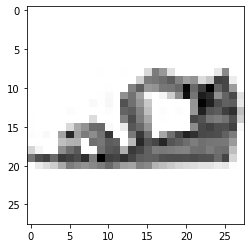

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm

img = X_train[random.randint(0,len(y_train))].reshape(28,28)

plt.imshow(img, cmap = matplotlib.cm.binary, interpolation="nearest")

Nun können wir uns dem eigentlichen Klassifikationsproblem widmen.
Wir verwenden an dieser Stelle ein logistisches Regressionsmodell mit einer one-versus-all Strategie, um die Klassen für die einzelnen Kleidungsstücke und Accessoires vorauszusagen.

Im Vergleich zu den bisher betrachteten Datensätzen, sind die Fashion MNIST Daten sehr umfangreich.
Daher ist auch die Berechnung der Modellparameter wesentlich komplexer und zeitaufwendiger als bei den Beispielen zuvor.
Wir sollten daher darauf achten, dass einmal berechnete Parameter nicht verlorengehen, etwa, weil das Programm, bzw. das Python-Notebook geschlossen wird.

Um die berechneten Modellparameter in eine Datei zu speichern, verwenden wir die Bibliothek Pickle (zu deutsch *einmachen*, *einlegen* oder auch *Essiggurke*).
Mit Pickle kann man Python Objekte serialisiert in eine Datei schreiben.
Dabei bleibt die komplette Struktur des Objekts intakt, sodass das Objekt aus der Datei wieder vollständig hergestellt werden kann.

Sobald ein Modell berechnet wurde, speichern wir es in eine Datei.
Wird die Code-Zelle später erneut ausgeführt, laden wir die Daten aus der Datei ein, anstatt das Modell erneut zu trainieren.

In [ ]:
import os
import pickle
from sklearn.linear_model import LogisticRegression

filename = 'logreg_fashion_mnist.mod'
if os.path.isfile(filename):
    logreg = pickle.load(open(filename, 'rb'))
else:    
    #logreg = LogisticRegression(multi_class="ovr")
    logreg = LogisticRegression(max_iter=10, solver='lbfgs',multi_class='ovr', n_jobs=-1)
    logreg.fit(X_train, y_train)
    pickle.dump(logreg, open(filename, 'wb'))

Zur Überprüfung der Vorhersagegenauigkeit können wir die sklearn-Funktion `score` verwenden.
Sie berechnet die den Anteil der korrekten Vorhersagen über alle Klassen.
Eine Vorhersage ist korrekt, wenn die Vorhergesagte Klasse mit der tatsächlichen Klasse übereinstimmt.

In [ ]:
# load the model from disk
saved_model = pickle.load(open(filename, 'rb'))
result = saved_model.score(X_test, y_test)
print("Vorhersagegenauigkeit (Testdaten): %.2f%%" % (result*100))
result = saved_model.score(X_train, y_train)
print("Vorhersagegenauigkeit (Trainingsdaten): %.2f%%" % (result*100))

**Aufgabe:** Berechnen Sie die Vorhersagegenauigkeit ohne die `score`-Funktion zu verwenden.

In [ ]:
# acc_test: the ratio of correctly predected labels to the size of the test set (between 0 and 1)

acc_test = None
# YOUR CODE HERE
raise NotImplementedError()

print("Vorhersagegenauigkeit (Testdaten): %.2f%%" % (acc_test*100))

In [ ]:
# Test Cell
#----------

assert 0 <= acc_test <= 1
assert acc_test == saved_model.score(X_test, y_test)

Die Konfusionsmatrix ist eine Tabelle, die für jede Klasse die Anzahl der übereinstimmenden Vorhersagen darstellt.
In den Zeilen der Matrix sind die tatsächlichen Klassen aufgetragen, in den Spalten die vorhergesagten Klassen.
Die Werte auf der Diagonalen der Matrix sind demnach korrekte Vorhersagen, die Werte ausserhalb der Diagonalen sind fehlerhafte Vorhersagen.

Die Konfusionsmatrix kann mit der Funktion `sklearn.metrics.confusion_matrix` berechnet werden.

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = logreg.predict(X_test)
confusion_matrix(y_test, y_pred)

**Aufgabe:** Berechnen Sie die Konfusionsmatrix ohne die Funktion `confusion_matrix` zu verwenden.

In [ ]:
# classes: Anzahl der Klassen
# cm: Konfusionsmatrix (Tatsächliche Klassen in Zeilen, vorhergesagte Klassen in Spalten)

classes = sorted(list(set(y_test)))
cm = []
for i in classes:
    pass
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Test Cell
#----------

cm = np.array(cm)
n = len(set(y_test))
assert cm.shape == (n, n)
assert np.array_equal(cm, confusion_matrix(y_test, y_pred))

cm

Weitere Metriken zur Bewertung des Modells sind die Relevanz (auch Genauigkeit oder positiver Vorhersagewert; engl. precision oder positive predictive value) und die Sensitivität (auch Richtig-positiv-Rate oder Trefferquote; engl. sensitivity oder recall).

In [ ]:
from sklearn.metrics import precision_score, recall_score

y_test_c0 = [y_test==0][0]*1
y_pred_c0 = [y_pred==0][0]*1

precision_score(y_test_c0, y_pred_c0), recall_score(y_test_c0, y_pred_c0)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/422px-Precisionrecall.svg.png)

**Aufgabe:** Berechnen Sie die Relevanz und die Sensitivität ohne die Funktionen `precision_score` und `recall_score` zu verwenden.

In [ ]:
def precision_recall(y_true_c0, y_pred_c0):
    '''
    Berechne zuerst die Anzahl der
     - true positives  (TP)
     - false positives (FP)
     - false negatives (FN)
    Mit diesen Werten kann dann die Relevanz und die Sensitivitaet 
    berechent werden.
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return precision, recall

In [ ]:
# Test Cell
#----------

assert precision_recall(y_test_c0, y_pred_c0) == (precision_score(y_test_c0, y_pred_c0), recall_score(y_test_c0, y_pred_c0))